In [2]:
import os
import json
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import chain

import numpy as np
import pandas as pd
from tqdm import tqdm

import nibabel as nib
import matplotlib.pyplot as plt


In [3]:
_IGNORE_MR_NA = True

In [4]:
DIR_PELVIS = os.path.join(os.getcwd(), "..", "data", "Task1", "pelvis")
HU_THRESHOLD = 2000
list_pelvis_image_dir = [os.path.join(DIR_PELVIS, f) for f in os.listdir(DIR_PELVIS) if f.startswith("1P")]

DIR_LABELS = os.path.join(os.getcwd(), "..", "labels")
FILE_MISSING = os.path.join(DIR_LABELS, "missing_Ömer.txt")
LABELS_RAW = os.path.join(DIR_LABELS, "labels_raw.json")

In [5]:
df_stats = pd.read_json(os.path.join(DIR_LABELS, "ct_hu_stats_pelvis.json"))
with open(LABELS_RAW, "r") as f:
    labels_raw_1 = json.load(f)["type1"]
df_labels_1 = pd.DataFrame([
    {"id": k, **v} 
    for item in labels_raw_1 
    for k, v in item.items()
])
with open(FILE_MISSING, "r") as f:
    list_missing = [line.strip() for line in f.readlines()]
df_stats_available = df_stats[~df_stats["id"].isin(list_missing)]
df_stats_available

,id,num_slices,slice_indexes,HU_above_2000,max_HU
29,1PA073,98,[],0,1529
30,1PA070,116,"[50, 51, 52, 54, 55, 56, 57]",7,3000
33,1PA080,98,"[35, 36, 37, 38, 39, 40, 41, 42]",8,3000
34,1PA081,119,"[44, 45, 46, 47, 48, 50, 51, 52, 53]",9,3000
38,1PA062,146,[],0,1471
...,...,...,...,...,...
175,1PC085,101,"[22, 23, 24]",3,2836
176,1PC088,104,[29],1,2192
177,1PC096,87,[49],1,2781
178,1PC098,104,"[42, 43, 44]",3,3000


In [6]:
df_labels_1_pelvis = df_labels_1[df_labels_1["body_part"] == "pelvis"]
if _IGNORE_MR_NA:
    df_labels_1_pelvis = df_labels_1_pelvis[df_labels_1_pelvis['mr_start'].notna()]
df_labels_1_pelvis[["mr_start", "mr_end", "ct_start", "ct_end"]] = \
    df_labels_1_pelvis[["mr_start", "mr_end", "ct_start", "ct_end"]].astype(int).sort_index()
df_labels_1_pelvis

,id,mr_start,mr_end,ct_start,ct_end,body_part
50,1PA118,0,104,3,76,pelvis
51,1PA133,74,82,74,82,pelvis
52,1PA136,98,121,100,121,pelvis
53,1PA147,45,53,45,53,pelvis
54,1PA151,47,53,46,54,pelvis
55,1PA152,56,69,56,68,pelvis
56,1PA155,6,131,15,86,pelvis
57,1PA163,0,79,0,64,pelvis
61,1PA169,4,97,8,82,pelvis
62,1PA170,25,39,25,39,pelvis


In [7]:
df_labels_1_pelvis_ood = df_labels_1_pelvis[["id", "ct_start", "ct_end"]]
df_labels_1_pelvis_ood["slice_indexes"] = df_labels_1_pelvis_ood.apply(lambda x: list(range(x["ct_start"], x["ct_end"] + 1)), axis=1)
df_labels_1_pelvis_ood = df_labels_1_pelvis_ood[["id", "slice_indexes"]]
df_labels_1_pelvis_ood = df_labels_1_pelvis_ood.groupby("id").agg(lambda x: list(chain.from_iterable(x))).reset_index()
df_labels_1_pelvis_ood

/tmp/ipykernel_265948/2100416103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels_1_pelvis_ood["slice_indexes"] = df_labels_1_pelvis_ood.apply(lambda x: list(range(x["ct_start"], x["ct_end"] + 1)), axis=1)


,id,slice_indexes
0,1PA065,"[93, 94, 95, 96, 97]"
1,1PA079,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17..."
2,1PA114,"[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 7..."
3,1PA118,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
4,1PA133,"[74, 75, 76, 77, 78, 79, 80, 81, 82]"
5,1PA136,"[100, 101, 102, 103, 104, 105, 106, 107, 108, ..."
6,1PA147,"[45, 46, 47, 48, 49, 50, 51, 52, 53]"
7,1PA151,"[46, 47, 48, 49, 50, 51, 52, 53, 54]"
8,1PA152,"[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 6..."
9,1PA155,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2..."


## scan level coverage

In [8]:
df_ = df_stats_available.merge(df_labels_1_pelvis_ood, on="id", how="left", suffixes=("_hu", "_man"))
df_.loc[:, "slice_indexes_man"] = df_["slice_indexes_man"].apply(
    lambda x: x if isinstance(x, list) else []
)
df_

,id,num_slices,slice_indexes_hu,HU_above_2000,max_HU,slice_indexes_man
0,1PA073,98,[],0,1529,[]
1,1PA070,116,"[50, 51, 52, 54, 55, 56, 57]",7,3000,[]
2,1PA080,98,"[35, 36, 37, 38, 39, 40, 41, 42]",8,3000,[]
3,1PA081,119,"[44, 45, 46, 47, 48, 50, 51, 52, 53]",9,3000,[]
4,1PA062,146,[],0,1471,[]
...,...,...,...,...,...,...
139,1PC085,101,"[22, 23, 24]",3,2836,[]
140,1PC088,104,[29],1,2192,[]
141,1PC096,87,[49],1,2781,[]
142,1PC098,104,"[42, 43, 44]",3,3000,[]


=== Summary ===
OOD Scans: 29
Average Coverage: 0.56
Median Coverage: 0.71
Proportion Covered (%): 72.41


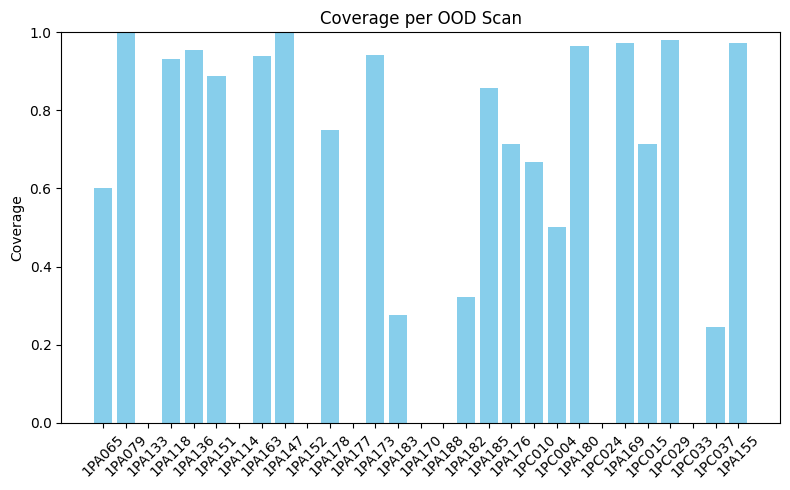

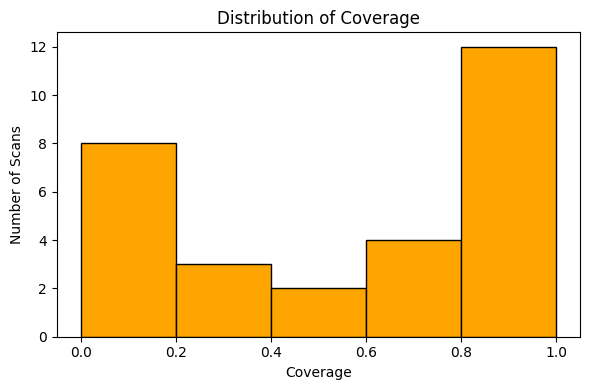

In [9]:
df = df_.copy()

def to_int_array(x):
    return np.array(x, dtype=int) if isinstance(x, (list, np.ndarray)) else np.array([], dtype=int)

df["hu_arr"] = df["slice_indexes_hu"].apply(to_int_array)
df["man_arr"] = df["slice_indexes_man"].apply(to_int_array)

# Keep manual labeled positive only
df_ood = df[df["man_arr"].apply(len) > 0].copy()

# Compute intersection and coverage
df_ood["intersection"] = df_ood.apply(lambda r: np.intersect1d(r["hu_arr"], r["man_arr"]), axis=1)
df_ood["n_man"] = df_ood["man_arr"].apply(len)
df_ood["n_hu"] = df_ood["hu_arr"].apply(len)
df_ood["n_intersection"] = df_ood["intersection"].apply(len)
df_ood["coverage_scan"] = df_ood["n_intersection"] / df_ood["n_man"]
df_ood["any_covered"] = df_ood["n_intersection"] > 0

# Summary
summary = {
    "OOD Scans": len(df_ood),
    "Average Coverage": df_ood["coverage_scan"].mean(),
    "Median Coverage": df_ood["coverage_scan"].median(),
    "Proportion Covered (%)": df_ood["any_covered"].mean() * 100
}
print("=== Summary ===")
for k,v in summary.items():
    print(f"{k}: {v:.2f}" if isinstance(v,float) else f"{k}: {v}")

# 
plt.figure(figsize=(8,5))
plt.bar(df_ood["id"], df_ood["coverage_scan"], color="skyblue")
plt.ylabel("Coverage")
plt.title("Coverage per OOD Scan")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("coverage_bar.png")
plt.show()

# Histogram 
plt.figure(figsize=(6,4))
plt.hist(df_ood["coverage_scan"], bins=np.linspace(0,1,6), color="orange", edgecolor="black")
plt.xlabel("Coverage")
plt.ylabel("Number of Scans")
plt.title("Distribution of Coverage")
plt.tight_layout()
# plt.savefig("coverage_hist.png")
plt.show()


In [10]:
# df = df_.copy()
# df["hu_arr"]  = df["slice_indexes_hu"].apply(lambda x: np.array(x, dtype=int))
# df["man_arr"] = df["slice_indexes_man"].apply(lambda x: np.array(x, dtype=int))

# df_ood = df[df["man_arr"].apply(len) > 0].copy()

# # 
# df_ood["intersection"] = df_ood.apply(lambda r: np.intersect1d(r["hu_arr"], r["man_arr"]), axis=1)
# df_ood["n_man"] = df_ood["man_arr"].apply(len)
# df_ood["n_hu"]  = df_ood["hu_arr"].apply(len)
# df_ood["n_intersection"] = df_ood["intersection"].apply(len)

# # Recall & Precision
# df_ood["recall"] = df_ood["n_intersection"] / df_ood["n_man"]
# df_ood["precision"] = df_ood.apply(lambda r: r["n_intersection"]/r["n_hu"] if r["n_hu"]>0 else np.nan, axis=1)

# # Summary
# summary = {
#     "macro_recall": df_ood["recall"].mean(),
#     "macro_precision": df_ood["precision"].mean(),
#     "micro_recall": df_ood["n_intersection"].sum() / df_ood["n_man"].sum(),
#     "micro_precision": df_ood["n_intersection"].sum() / df_ood["n_hu"].sum()
# }

# print("=== Scan-level recall & precision ===")
# print(df_ood[["id","n_man","n_hu","n_intersection","recall","precision"]])
# print("\n=== Summary ===")
# for k,v in summary.items():
#     print(f"{k}: {v:.3f}")


## Scan Level Recall & Precision

=== Scan-level Metrics ===
TP: 23, FP: 72, FN: 6, TN: 43
Recall: 0.793, Precision: 0.242, F1: 0.371
=== Scan-level Confusion Matrix ===
             Label=Pos  Label=Neg
HU>2000=Pos         23         72
HU<2000=Neg          6         43


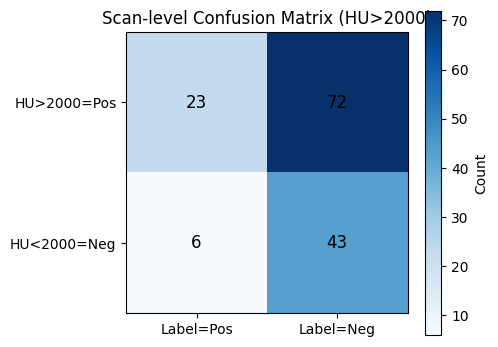

In [11]:
df = df_.copy()

def to_int_array(x):
    if isinstance(x, (list, np.ndarray)):
        return np.array(x, dtype=int)
    if isinstance(x, str):
        s = x.strip("[] ")
        if not s:
            return np.array([], dtype=int)
        return np.array([int(v) for v in s.replace(",", " ").split() if v.isdigit()], dtype=int)
    return np.array([], dtype=int)

df["hu_arr"]  = df["slice_indexes_hu"].apply(to_int_array)
df["man_arr"] = df["slice_indexes_man"].apply(to_int_array)

df["pred_pos"] = df["hu_arr"].apply(lambda x: len(x) > 0)
df["true_pos"] = df["man_arr"].apply(lambda x: len(x) > 0)

# confusion matrix
TP = ((df["pred_pos"] == True)  & (df["true_pos"] == True)).sum()
FP = ((df["pred_pos"] == True)  & (df["true_pos"] == False)).sum()
FN = ((df["pred_pos"] == False) & (df["true_pos"] == True)).sum()
TN = ((df["pred_pos"] == False) & (df["true_pos"] == False)).sum()

conf_matrix = pd.DataFrame(
    [[TP, FP],
     [FN, TN]],
    index=["HU>2000=Pos","HU<2000=Neg"],
    columns=["Label=Pos","Label=Neg"]
)

recall = TP / (TP + FN) if (TP+FN) > 0 else np.nan
precision = TP / (TP + FP) if (TP+FP) > 0 else np.nan
f1 = 2*precision*recall/(precision+recall) if precision+recall > 0 else np.nan
print("=== Scan-level Metrics ===")
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")

print("=== Scan-level Confusion Matrix ===")
print(conf_matrix)

# Visualization 
plt.figure(figsize=(5,4))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar(label="Count")
plt.xticks([0,1], conf_matrix.columns)
plt.yticks([0,1], conf_matrix.index)
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix.iloc[i,j], ha="center", va="center", color="black", fontsize=12)
plt.title("Scan-level Confusion Matrix (HU>2000)")
plt.tight_layout()
plt.savefig("scan_level_confusion_matrix.png")
plt.show()
